# Pull all Tesla articles from The Guardian API

In this notebook we will use the guardian API in order to obtain a collection of document talking about the car manufacturer Tesla. This will be our dataset to extract information from it concerning the company and test the possibilities using spaCy NER model.

## Imports

In [1]:
import re
import copy

import pandas as pd
import matplotlib.pyplot as plt

from time import sleep
from datetime import datetime
from tqdm.notebook import tqdm

from bs4 import BeautifulSoup

from theguardian import theguardian_tag
from theguardian import theguardian_content

from config import API_KEY

## Query one topic

In our case we will chose the car manuacturer Tesla.

In [2]:
def get_query_results(q, section):
    # get the apple tags
    headers = {
        "q": q,
        "section": section,
    }
    tag = theguardian_tag.Tag(api=API_KEY, **headers)

    # get the results
    tag_content = tag.get_content_response()
    results = tag.get_results(tag_content)
    return results

### The query results below give us access to a API URL to pull all the articles from this topic

In [3]:
results = get_query_results("tesla", 'technology')
results

[{'id': 'technology/tesla',
  'type': 'keyword',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webTitle': 'Tesla',
  'webUrl': 'https://www.theguardian.com/technology/tesla',
  'apiUrl': 'https://content.guardianapis.com/technology/tesla',
  'description': 'Tesla is an automotive and energy storage company that designs, manufactures, and sells electric cars, electric vehicle powertrain components, and battery products.'}]

## Pull all the articles reference coresponding to the Tesla topic
To do so we use the URL from the previous cells.

In [4]:
def get_list_of_article_url(tag_apiUrl):
    content = theguardian_content.Content(api=API_KEY, url=tag_apiUrl)#,  page=41)
    content_response = content.get_content_response()
    nb_pages = content_response['response']['pages']
    list_of_results_informations = []
    for p in tqdm(range(1, nb_pages+1)):
        response = theguardian_content.Content(api=API_KEY, url=tag_apiUrl,
                                               page=p).get_content_response()
        for res in response['response']['results']:
            list_of_results_informations.append({
                "id": res["id"].replace('/', '_'),
                "type": res['type'],
                'sectionId': res['sectionId'],
                'webPublicationDate': res['webPublicationDate'],
                'webTitle': res['webTitle'],
                'webUrl': res['webUrl'],
                'apiUrl': res['apiUrl']
            })
        sleep(0.1) # I am only allowed 12 request a second 
    results_informations_df = pd.DataFrame(list_of_results_informations)
    return results_informations_df

In [5]:
results = get_query_results("tesla", 'technology')
tesla_theguardian_df = get_list_of_article_url(results[0]["apiUrl"])

  0%|          | 0/41 [00:00<?, ?it/s]

### List of all articles metadata
This contains the articles dates, types, sections, Title, but most importantly, the API url which will allow us to access the whole article.

In [6]:
tesla_theguardian_df

,id,type,sectionId,webPublicationDate,webTitle,webUrl,apiUrl
0,business_nils-pratley-on-finance_2021_may_24_l...,article,business,2021-05-24T19:16:31Z,"Liberty Steel wants to buy time, but who will ...",https://www.theguardian.com/business/nils-prat...,https://content.guardianapis.com/business/nils...
1,business_nils-pratley-on-finance_2021_may_19_t...,article,business,2021-05-19T19:10:54Z,The 30% one-day fall in bitcoin’s value looks ...,https://www.theguardian.com/business/nils-prat...,https://content.guardianapis.com/business/nils...
2,business_2021_may_13_fund-management-irretriev...,article,business,2021-05-13T16:27:08Z,"Fund management ‘irretrievably broken’, says s...",https://www.theguardian.com/business/2021/may/...,https://content.guardianapis.com/business/2021...
3,business_2021_may_05_uk-car-sales-rebound-afte...,article,business,2021-05-05T09:21:07Z,UK car sales rebound after ‘one of darkest yea...,https://www.theguardian.com/business/2021/may/...,https://content.guardianapis.com/business/2021...
4,business_2021_apr_28_us-automakers-rules-auto-...,article,technology,2021-04-28T16:49:27Z,US automakers outline rules for auto-driving c...,https://www.theguardian.com/business/2021/apr/...,https://content.guardianapis.com/business/2021...
...,...,...,...,...,...,...,...
401,media_2008_dec_24_jeremy-clarkson-top-gear-tes...,article,tv-and-radio,2008-12-24T07:11:09Z,Top Gear's Jeremy Clarkson under fire over Tes...,https://www.theguardian.com/media/2008/dec/24/...,https://content.guardianapis.com/media/2008/de...
402,technology_blog_2008_dec_01_engineering-automo...,article,technology,2008-12-01T22:42:56Z,Why Obama should treat the car industry like t...,https://www.theguardian.com/technology/blog/20...,https://content.guardianapis.com/technology/bl...
403,environment_2008_oct_16_alternativeenergy-usa,article,environment,2008-10-16T08:20:53Z,Electric car manufacturer hit by financial crisis,https://www.theguardian.com/environment/2008/o...,https://content.guardianapis.com/environment/2...
404,business_2008_jul_01_automotive.greenbusiness,article,business,2008-07-01T16:06:40Z,California beats New Mexico in race to build z...,https://www.theguardian.com/business/2008/jul/...,https://content.guardianapis.com/business/2008...


#### Convert string publication datetime to python datetime objects

In [7]:
tesla_theguardian_df.loc[:, "webPublicationDate"] = tesla_theguardian_df["webPublicationDate"].apply(lambda dt: datetime.strptime(dt, "%Y-%m-%dT%H:%M:%SZ"))

### Quick look at the repartition through time of the Tesla articles

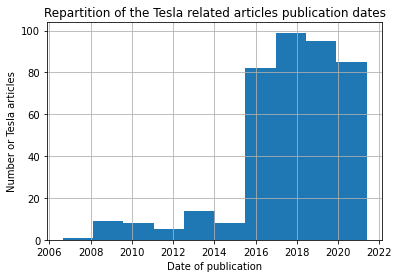

In [8]:
plt.title("Repartition of the Tesla related articles publication dates")
tesla_theguardian_df.webPublicationDate.hist()
plt.xlabel("Date of publication")
plt.ylabel("Number or Tesla articles")
plt.show()

#### Save the dataframe of Tesla related articles

In [9]:
tesla_theguardian_df.to_csv('/home/jupyter/data/ner/theguardian/tesla_theguardian_df.csv')

## Download every articles form the tesla articles dataframe
We will parse those articles with BeautifulSoup python package to remove all HTML elements. We will save the results in text files using the article id as filenames.


In [10]:
def dowload_articles_content(theguardian_df):
    
    header = {
        "show-fields": ["body"]
    }
    
    for article_key, article_api_uri in tqdm(theguardian_df[["id", "apiUrl"]].values):
        content = theguardian_content.Content(api=API_KEY, url=article_api_uri,
                                              **header).get_content_response()
        txt = content['response']['content']['fields']['body']
        preprocess_txt = BeautifulSoup(txt, 'html.parser').get_text()
        with open("/home/jupyter/data/ner/theguardian/articles/" + article_key + ".txt", "w") as f:
            f.write(preprocess_txt)
        sleep(0.1)


In [11]:
dowload_articles_content(tesla_theguardian_df)

  0%|          | 0/406 [00:00<?, ?it/s]